In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from scipy import integrate
from scipy.stats import linregress
from matplotlib import cm
from matplotlib.colors import ListedColormap
import scipy.stats as sc

In [2]:
#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  

In [3]:
#Make some standardized coordinates

lats = np.arange(-90, 91, 1)
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g
levels_pa = np.array([100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 60000,
             70000, 85000, 92500, 100000])
levels_hPa = levels_pa / 100

confidence_level = 0.95

In [7]:
amip_ds = xr.open_dataset('../AHT_trends_work/amip_aht.nc').sel(time=slice('1980-01-01','2014-12-31'))
hist_ds = xr.open_dataset('../AHT_trends_work/hist_aht.nc').sel(time=slice('1980-01-01','2014-12-31'))
reanalysis_ds = xr.open_dataset('../AHT_trends_work/reanalysis_aht.nc').sel(time=slice('1980-01-01','2014-12-31'))
cesm_ds = xr.open_dataset('../AHT_trends_work/CESM2_LENS2_aht_ds_1850_2014.nc').sel(time=slice('1980-01-01','2014-12-31'))

In [8]:
amip_sst = xr.open_dataset('../AHT_trends_work/amip_sst.nc').sel(time=slice('1980-01-01','2014-12-31'))
hist_sst = xr.open_dataset('../AHT_trends_work/hist_sst_ds.nc').sel(time=slice('1980-01-01','2014-12-31'))
obs_sst = xr.open_dataset('../AHT_trends_work/ersstv5.nc').sel(time=slice('1980-01-01','2014-12-31'))
cesm_sst = xr.open_dataset('../AHT_trends_work/cesm2_sst.nc').sel(time=slice('1980-01-01','2014-12-31'))

In [9]:
common_models = np.intersect1d(hist_sst.model.values, hist_ds.model.values)

hist_ds = hist_ds.sel(model=common_models)
hist_sst = hist_sst.sel(model=common_models)

In [10]:
hist_std_error = xr.open_dataset('../AHT_trends_work/hist_ds_trend_std_error.nc')
cesm_std_error = xr.open_dataset('../AHT_trends_work/cesm2_le_ds_trend_std_error.nc')
hist_Neff = xr.open_dataset('../AHT_trends_work/hist_ds_trend_Neff.nc')
cesm_Neff = xr.open_dataset('../AHT_trends_work/cesm2_le_ds_trend_Neff.nc')

In [11]:
hist_sst_std_error = xr.open_dataset('../AHT_trends_work/hist_sst_trend_std_error.nc')
cesm_sst_std_error = xr.open_dataset('../AHT_trends_work/cesm_sst_trend_std_error.nc')
hist_sst_Neff = xr.open_dataset('../AHT_trends_work/hist_sst_trend_Neff.nc')
cesm_sst_Neff = xr.open_dataset('../AHT_trends_work/cesm_sst_trend_Neff.nc')

In [12]:
hist_std_error = hist_std_error.sel(model=common_models)
hist_Neff = hist_Neff.sel(model=common_models)

hist_sst_std_error = hist_sst_std_error.sel(model=common_models)
hist_sst_Neff = hist_sst_Neff.sel(model=common_models)

In [13]:
amip_trends = amip_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
hist_trends = hist_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
reanalysis_trends = reanalysis_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
cesm_trends = cesm_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)

In [14]:
amip_sst_trends = amip_sst.mean('lon', skipna=True).groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
hist_sst_trends = hist_sst.mean('lon', skipna=True).groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
obs_sst_trends = obs_sst.mean('lon', skipna=True).groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
cesm_sst_trends = cesm_sst.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)



In [15]:
def violin_plot(data, ax, x_point):
    
    x_point = x_point.values
    violin_width = 0.8

    parts = ax.violinplot(data, positions=[x_point], showmedians=False, showmeans=False, showextrema=False,
                    widths=violin_width)

    for pc in parts['bodies']:
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
        pc.set_alpha(0.3)
        
    

    quartile1, median, quartile3 = np.percentile(data, [25, 50, 75])
    
    mean = np.mean(data)

    #ax.scatter(inds, [median1, median2], marker='o', color='white', s=30, zorder=3)
    #ax.scatter(x_point, mean, marker='o', color='white', s=30, zorder=3)
    ax.vlines(x_point, quartile1, quartile3, color='k', linestyle='-', lw=5, zorder=3)
    #ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

<ipython-input-16-a021fdaf6b86>:53: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(40 * cesm_sst_dif.where(~both_sig_cesm), 40 / 1e15 * cesm_aht_slice.where(~both_sig_cesm), edgecolor='grey', facecolor='')
<ipython-input-16-a021fdaf6b86>:72: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(40 * hist_sst_dif.where(~both_sig_hist), 40 / 1e15 * hist_aht_slice.where(~both_sig_hist), edgecolor='purple', facecolor='')


0.4314230035555791


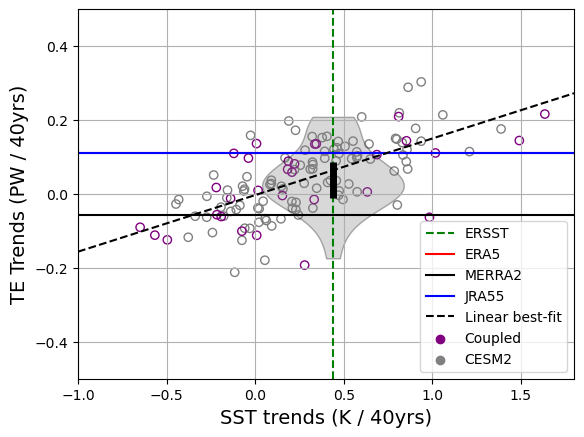

In [16]:
lat11 = 40
lat12 = 41

lat21 = 50
lat22 = 51

sst_lat1 = slice(lat11, lat12)
sst_lat2 = slice(lat21, lat22)
sst_lat1_obs = slice(lat12, lat11)
sst_lat2_obs = slice(lat22, lat21)

aht_lat = slice(49.5, 50.5)

hist_sst_slice1 = hist_sst_trends.ts_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat1).mean('lat')
hist_sst_slice2 = hist_sst_trends.ts_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat2).mean('lat')
hist_sst_dif = hist_sst_slice1 - hist_sst_slice2

obs_sst_slice1 = obs_sst_trends.sst_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat1_obs).mean('lat')
obs_sst_slice2 = obs_sst_trends.sst_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat2_obs).mean('lat')
obs_sst_dif = obs_sst_slice1 - obs_sst_slice2

amip_sst_slice1 = amip_sst_trends.tosbcs_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat1).mean('lat')
amip_sst_slice2 = amip_sst_trends.tosbcs_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat2).mean('lat')
amip_sst_dif = amip_sst_slice1 - amip_sst_slice2

cesm_sst_slice1 = cesm_sst_trends.SST_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat1).mean('lat')
cesm_sst_slice2 = cesm_sst_trends.SST_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat2).mean('lat')
cesm_sst_dif = cesm_sst_slice1 - cesm_sst_slice2

amip_aht_slice = amip_trends.te_aht_polyfit_coefficients.sel(latitude=aht_lat).sel(degree=1).mean('latitude')
hist_aht_slice = hist_trends.te_aht_polyfit_coefficients.sel(latitude=aht_lat).sel(degree=1).mean('latitude')
cesm_aht_slice = cesm_trends.te_aht_polyfit_coefficients.sel(latitude=aht_lat).sel(degree=1).mean('latitude')
reanalysis_aht_slice = reanalysis_trends.te_aht_polyfit_coefficients.sel(latitude=aht_lat).sel(degree=1).mean('latitude')


cesm_Neff_val11 = cesm_sst_Neff.SST.sel(latitude=sst_lat1).mean('latitude')
cesm_Neff_val12 = cesm_sst_Neff.SST.sel(latitude=sst_lat2).mean('latitude')
cesm_Neff_val1 = (cesm_Neff_val11 + cesm_Neff_val12)/2
cesm_Neff_val2 = cesm_Neff.te_aht.sel(latitude=aht_lat).mean('latitude')
t_vals_cesm1 = sc.t.ppf((1 + confidence_level)/2, cesm_Neff_val1.values)
t_vals_cesm2 = sc.t.ppf((1 + confidence_level)/2, cesm_Neff_val2.values)
cesm_sst_err1 = cesm_sst_std_error.SST.sel(latitude=sst_lat1).mean('latitude')
cesm_sst_err2 = cesm_sst_std_error.SST.sel(latitude=sst_lat2).mean('latitude')
cesm_sst_err = np.sqrt(cesm_sst_err1 ** 2 + cesm_sst_err2 ** 2)
t_values1_cesm = cesm_sst_dif / (cesm_sst_err)
t_values2_cesm = cesm_aht_slice / (cesm_std_error.te_aht.sel(latitude=aht_lat).mean('latitude'))
val1_sig_cesm = xr.where(abs(t_values1_cesm) > t_vals_cesm1, True, False)
val2_sig_cesm = xr.where(abs(t_values2_cesm) > t_vals_cesm2, True, False)

both_sig_cesm = np.logical_and(val1_sig_cesm, val2_sig_cesm)

plt.scatter(40 * cesm_sst_dif.where(both_sig_cesm), 40 / 1e15 * cesm_aht_slice.where(both_sig_cesm), color='grey')
plt.scatter(40 * cesm_sst_dif.where(~both_sig_cesm), 40 / 1e15 * cesm_aht_slice.where(~both_sig_cesm), edgecolor='grey', facecolor='')

hist_Neff_val11 = hist_sst_Neff.ts.sel(latitude=sst_lat1).mean('latitude')
hist_Neff_val12 = hist_sst_Neff.ts.sel(latitude=sst_lat2).mean('latitude')
hist_Neff_val1 = (hist_Neff_val11 + hist_Neff_val12)/2
hist_Neff_val2 = hist_Neff.te_aht.sel(latitude=aht_lat).mean('latitude')
t_vals_hist1 = sc.t.ppf((1 + confidence_level)/2, hist_Neff_val1.values)
t_vals_hist2 = sc.t.ppf((1 + confidence_level)/2, hist_Neff_val2.values)
hist_sst_err1 = hist_sst_std_error.ts.sel(latitude=sst_lat1).mean('latitude')
hist_sst_err2 = hist_sst_std_error.ts.sel(latitude=sst_lat2).mean('latitude')
hist_sst_err = np.sqrt(hist_sst_err1 ** 2 + hist_sst_err2 ** 2)
t_values1_hist = hist_sst_dif / (hist_sst_err)
t_values2_hist = hist_aht_slice / (hist_std_error.te_aht.sel(latitude=aht_lat).mean('latitude'))
val1_sig_hist = xr.where(abs(t_values1_hist) > t_vals_hist1, True, False)
val2_sig_hist = xr.where(abs(t_values2_hist) > t_vals_hist2, True, False)

both_sig_hist = np.logical_and(val1_sig_hist, val2_sig_hist)

plt.scatter(40 * hist_sst_dif.where(both_sig_hist), 40 / 1e15 * hist_aht_slice.where(both_sig_hist), color='purple')
plt.scatter(40 * hist_sst_dif.where(~both_sig_hist), 40 / 1e15 * hist_aht_slice.where(~both_sig_hist), edgecolor='purple', facecolor='')


plt.scatter(40, 40, color='purple', label='Coupled')
plt.scatter(40, 40, color='grey', label='CESM2')

plt.axvline(obs_sst_dif * 40, linestyle='--', color='g', label='ERSST')

violin_plot(amip_aht_slice * 40 / 1e15, plt, obs_sst_dif * 40)

#plt.axvline(amip_sst_dif * 40, color='r')
plt.axhline(reanalysis_aht_slice.sel(model='ERA5').values * 40 / 1e15, color='r', label='ERA5')
plt.axhline(reanalysis_aht_slice.sel(model='MERRA').values * 40 / 1e15, color='k', label='MERRA2')
plt.axhline(reanalysis_aht_slice.sel(model='JRA').values * 40 / 1e15, color='b', label='JRA55')

all_ahts = []
all_ahts.append(hist_aht_slice.values)
all_ahts.append(cesm_aht_slice.values)
all_ahts = np.hstack(all_ahts)

all_ssts = []
all_ssts.append(hist_sst_dif.values)
all_ssts.append(cesm_sst_dif.values)
all_ssts = np.hstack(all_ssts)

linregress_sst_aht = linregress(40 * (all_ssts), all_ahts * 40 / 1e15)
slope = linregress_sst_aht.slope
int_val = linregress_sst_aht.intercept
r_val = linregress_sst_aht.rvalue
p_val = linregress_sst_aht.pvalue


plt.plot(np.linspace(-1, 1.8, 50), int_val + np.linspace(-1, 1.8, 50) * slope, '--', color='k',
        label='Linear best-fit')

plt.legend(loc=0)
print(r_val ** 2)

plt.xlabel('SST trends (K / 40yrs)', fontsize=14)
plt.ylabel('TE Trends (PW / 40yrs)', fontsize=14)

plt.xlim([-1, 1.8])
plt.ylim([-0.5, 0.5])
plt.grid()
#plt.savefig('../figures/50n_sst_te_scatter')
plt.show()

In [17]:
amip_aht_slice

<xarray.DataArray 'te_aht_polyfit_coefficients' (model: 28)>
array([ 5.11047922e+11,  4.05634770e+12,  1.81675004e+11, -2.55095780e+11,
        1.59701326e+12, -2.04467251e+12,  1.36963997e+12,  7.42697797e+11,
        3.93238159e+12,  4.90769106e+11,  1.59001593e+12, -4.35653288e+12,
       -3.93202242e+11, -4.59793821e+11,  2.33267736e+12,  2.63953384e+12,
        2.11272185e+12, -2.49851206e+11, -2.36985633e+12,  4.80054059e+12,
        6.84340498e+11,  1.17720725e+12, -3.33522676e+09,  5.21310865e+12,
        1.64896507e+12, -3.27538341e+11,  4.82541411e+12, -1.12603703e+12])
Coordinates:
    degree   int64 1
  * model    (model) object 'NorESM2-LM' 'TaiESM1' ... 'BCC-ESM1' 'CAS-ESM2-0'

0.23767633177654174


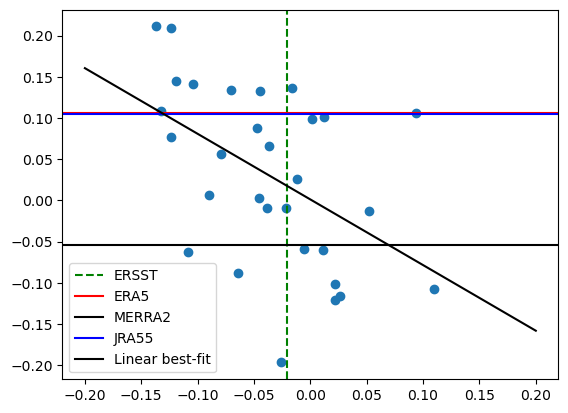

In [18]:
lat11 = 43.5
lat12 = 44.5

lat21 = 53.5
lat22 = 54.5

sst_lat1 = slice(lat11, lat12)
sst_lat2 = slice(lat21, lat22)
sst_lat1_obs = slice(lat12, lat11)
sst_lat2_obs = slice(lat22, lat21)

aht_lat = slice(48, 52)
aht_lat_obs = slice(52, 48)

hist_sst_slice = hist_sst_trends.ts_polyfit_coefficients.sel(degree=1).differentiate('lat').sel(lat=aht_lat).mean('lat')

obs_sst_slice = obs_sst_trends.sst_polyfit_coefficients.sel(degree=1).differentiate('lat').sel(lat=aht_lat_obs).mean('lat')

hist_aht_slice = hist_trends.te_aht_polyfit_coefficients.sel(latitude=aht_lat).sel(degree=1).mean('latitude')
reanalysis_aht_slice = reanalysis_trends.te_aht_polyfit_coefficients.sel(latitude=aht_lat).sel(degree=1).mean('latitude')

plt.scatter(40 * (hist_sst_slice.values), 40 / 1e15 * hist_aht_slice.values)

plt.axvline(obs_sst_slice * 40, linestyle='--', color='g', label='ERSST')
plt.axhline(reanalysis_aht_slice.sel(model='ERA5').values * 40 / 1e15, color='r', label='ERA5')
plt.axhline(reanalysis_aht_slice.sel(model='MERRA').values * 40 / 1e15, color='k', label='MERRA2')
plt.axhline(reanalysis_aht_slice.sel(model='JRA').values * 40 / 1e15, color='b', label='JRA55')

linregress_sst_aht = linregress(40 * (hist_sst_slice), 40 / 1e15 * hist_aht_slice)
slope = linregress_sst_aht.slope
int_val = linregress_sst_aht.intercept
r_val = linregress_sst_aht.rvalue
p_val = linregress_sst_aht.pvalue


plt.plot(np.linspace(-0.2, 0.2, 50), int_val + np.linspace(-0.2, 0.2, 50) * slope, color='k',
        label='Linear best-fit')

plt.legend(loc=0)
print(r_val ** 2)
plt.show()

In [19]:
obs_sst_slice

<xarray.DataArray 'sst_polyfit_coefficients' ()>
array(-0.00050822)
Coordinates:
    degree   int64 1

<ipython-input-35-b59cbb9bacab>:52: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(40 * cesm_sst_dif.where(~both_sig_cesm), 40 / 1e15 * cesm_aht_slice.where(~both_sig_cesm), edgecolor='grey', facecolor='')
<ipython-input-35-b59cbb9bacab>:71: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(40 * hist_sst_dif.where(~both_sig_hist), 40 / 1e15 * hist_aht_slice.where(~both_sig_hist), edgecolor='purple', facecolor='')


0.4145415419825848


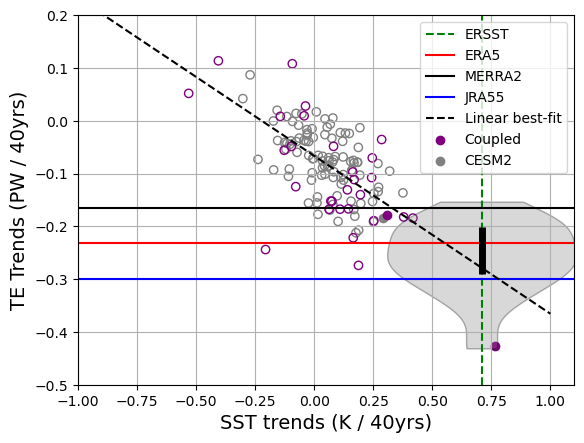

In [35]:
lat11 = -50
lat12 = -30

lat21 = -61
lat22 = -50

sst_lat1 = slice(lat11, lat12)
sst_lat2 = slice(lat21, lat22)
sst_lat1_obs = slice(lat12, lat11)
sst_lat2_obs = slice(lat22, lat21)

aht_lat = slice(-60, -55)

hist_sst_slice1 = hist_sst_trends.ts_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat1).mean('lat')
hist_sst_slice2 = hist_sst_trends.ts_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat2).mean('lat')
hist_sst_dif = hist_sst_slice1 - hist_sst_slice2

obs_sst_slice1 = obs_sst_trends.sst_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat1_obs).mean('lat')
obs_sst_slice2 = obs_sst_trends.sst_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat2_obs).mean('lat')
obs_sst_dif = obs_sst_slice1 - obs_sst_slice2

amip_sst_slice1 = amip_sst_trends.tosbcs_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat1).mean('lat')
amip_sst_slice2 = amip_sst_trends.tosbcs_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat2).mean('lat')
amip_sst_dif = amip_sst_slice1 - amip_sst_slice2

cesm_sst_slice1 = cesm_sst_trends.SST_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat1).mean('lat')
cesm_sst_slice2 = cesm_sst_trends.SST_polyfit_coefficients.sel(degree=1).sel(lat=sst_lat2).mean('lat')
cesm_sst_dif = cesm_sst_slice1 - cesm_sst_slice2

amip_aht_slice = amip_trends.te_aht_polyfit_coefficients.sel(latitude=aht_lat).sel(degree=1).mean('latitude')
hist_aht_slice = hist_trends.te_aht_polyfit_coefficients.sel(latitude=aht_lat).sel(degree=1).mean('latitude')
cesm_aht_slice = cesm_trends.te_aht_polyfit_coefficients.sel(latitude=aht_lat).sel(degree=1).mean('latitude')
reanalysis_aht_slice = reanalysis_trends.te_aht_polyfit_coefficients.sel(latitude=aht_lat).sel(degree=1).mean('latitude')

cesm_Neff_val11 = cesm_sst_Neff.SST.sel(latitude=sst_lat1).mean('latitude')
cesm_Neff_val12 = cesm_sst_Neff.SST.sel(latitude=sst_lat2).mean('latitude')
cesm_Neff_val1 = (cesm_Neff_val11 + cesm_Neff_val12)/2
cesm_Neff_val2 = cesm_Neff.te_aht.sel(latitude=aht_lat).mean('latitude')
t_vals_cesm1 = sc.t.ppf((1 + confidence_level)/2, cesm_Neff_val1.values)
t_vals_cesm2 = sc.t.ppf((1 + confidence_level)/2, cesm_Neff_val2.values)
cesm_sst_err1 = cesm_sst_std_error.SST.sel(latitude=sst_lat1).mean('latitude')
cesm_sst_err2 = cesm_sst_std_error.SST.sel(latitude=sst_lat2).mean('latitude')
cesm_sst_err = np.sqrt(cesm_sst_err1 ** 2 + cesm_sst_err2 ** 2)
t_values1_cesm = cesm_sst_dif / (cesm_sst_err)
t_values2_cesm = cesm_aht_slice / (cesm_std_error.te_aht.sel(latitude=aht_lat).mean('latitude'))
val1_sig_cesm = xr.where(abs(t_values1_cesm) > t_vals_cesm1, True, False)
val2_sig_cesm = xr.where(abs(t_values2_cesm) > t_vals_cesm2, True, False)

both_sig_cesm = np.logical_and(val1_sig_cesm, val2_sig_cesm)

plt.scatter(40 * cesm_sst_dif.where(both_sig_cesm), 40 / 1e15 * cesm_aht_slice.where(both_sig_cesm), color='grey')
plt.scatter(40 * cesm_sst_dif.where(~both_sig_cesm), 40 / 1e15 * cesm_aht_slice.where(~both_sig_cesm), edgecolor='grey', facecolor='')

hist_Neff_val11 = hist_sst_Neff.ts.sel(latitude=sst_lat1).mean('latitude')
hist_Neff_val12 = hist_sst_Neff.ts.sel(latitude=sst_lat2).mean('latitude')
hist_Neff_val1 = (hist_Neff_val11 + hist_Neff_val12)/2
hist_Neff_val2 = hist_Neff.te_aht.sel(latitude=aht_lat).mean('latitude')
t_vals_hist1 = sc.t.ppf((1 + confidence_level)/2, hist_Neff_val1.values)
t_vals_hist2 = sc.t.ppf((1 + confidence_level)/2, hist_Neff_val2.values)
hist_sst_err1 = hist_sst_std_error.ts.sel(latitude=sst_lat1).mean('latitude')
hist_sst_err2 = hist_sst_std_error.ts.sel(latitude=sst_lat2).mean('latitude')
hist_sst_err = np.sqrt(hist_sst_err1 ** 2 + hist_sst_err2 ** 2)
t_values1_hist = hist_sst_dif / (hist_sst_err)
t_values2_hist = hist_aht_slice / (hist_std_error.te_aht.sel(latitude=aht_lat).mean('latitude'))
val1_sig_hist = xr.where(abs(t_values1_hist) > t_vals_hist1, True, False)
val2_sig_hist = xr.where(abs(t_values2_hist) > t_vals_hist2, True, False)

both_sig_hist = np.logical_and(val1_sig_hist, val2_sig_hist)

plt.scatter(40 * hist_sst_dif.where(both_sig_hist), 40 / 1e15 * hist_aht_slice.where(both_sig_hist), color='purple')
plt.scatter(40 * hist_sst_dif.where(~both_sig_hist), 40 / 1e15 * hist_aht_slice.where(~both_sig_hist), edgecolor='purple', facecolor='')


plt.scatter(40, 40, color='purple', label='Coupled')
plt.scatter(40, 40, color='grey', label='CESM2')

plt.axvline(obs_sst_dif * 40, linestyle='--', color='g', label='ERSST')

violin_plot(amip_aht_slice * 40 / 1e15, plt, obs_sst_dif * 40)

#plt.axvline(amip_sst_dif * 40, color='r')
plt.axhline(reanalysis_aht_slice.sel(model='ERA5').values * 40 / 1e15, color='r', label='ERA5')
plt.axhline(reanalysis_aht_slice.sel(model='MERRA').values * 40 / 1e15, color='k', label='MERRA2')
plt.axhline(reanalysis_aht_slice.sel(model='JRA').values * 40 / 1e15, color='b', label='JRA55')

all_ahts = []
all_ahts.append(hist_aht_slice.values)
all_ahts.append(cesm_aht_slice.values)
all_ahts = np.hstack(all_ahts)

all_ssts = []
all_ssts.append(hist_sst_dif.values)
all_ssts.append(cesm_sst_dif.values)
all_ssts = np.hstack(all_ssts)

linregress_sst_aht = linregress(40 * (all_ssts), all_ahts * 40 / 1e15)
slope = linregress_sst_aht.slope
int_val = linregress_sst_aht.intercept
r_val = linregress_sst_aht.rvalue
p_val = linregress_sst_aht.pvalue


plt.plot(np.linspace(-1, 1, 50), int_val + np.linspace(-1, 1, 50) * slope, '--', color='k',
        label='Linear best-fit')

plt.legend(loc=0)
print(r_val ** 2)

plt.xlabel('SST trends (K / 40yrs)', fontsize=14)
plt.ylabel('TE Trends (PW / 40yrs)', fontsize=14)

plt.xlim([-1, 1.1])
plt.ylim([-0.5, 0.2])
plt.grid()
#plt.savefig('s_ocean_sst_te_scatter_models')
plt.show()

In [21]:
val2_sig_hist.sel(model='BCC-CSM2-MR')

<xarray.DataArray ()>
array(True)
Coordinates:
    degree   int64 1
    model    <U11 'BCC-CSM2-MR'

In [22]:
40 * hist_sst_dif.isel(model=hist_sst_dif.argmax('model').values)



<xarray.DataArray 'ts_polyfit_coefficients' ()>
array(0.72334871)
Coordinates:
    degree   int64 1
    model    <U11 'BCC-CSM2-MR'

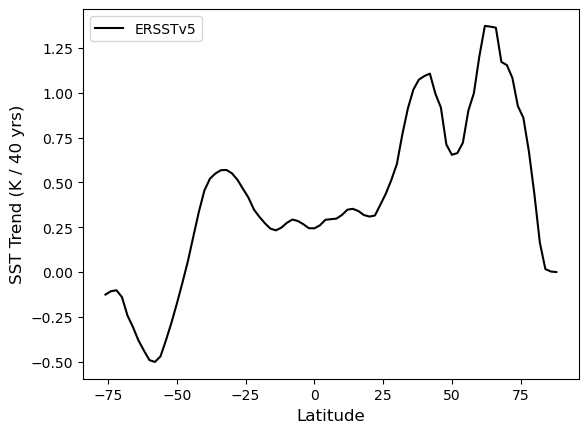

In [23]:
(40 * obs_sst_trends.sst_polyfit_coefficients.sel(degree=1)).plot(color='k', label='ERSSTv5')
#(40 * amip_sst_trends.tosbcs_polyfit_coefficients.sel(degree=1)).plot(label='AMIP')
#(40 * hist_sst_trends.ts_polyfit_coefficients.sel(model='BCC-CSM2-MR').sel(degree=1)).plot(label='BCC-CSM2-MR')

#plt.axvline(40)
#plt.axvline(50)
plt.legend(loc=0)

plt.xlabel('Latitude', fontsize=12)
plt.ylabel('SST Trend (K / 40 yrs)', fontsize=12)

plt.title('')

#plt.savefig('../figures/zonal_mean_sst_trends_ersst')
plt.show()